In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
import sys
import os
sys.path.append(os.path.abspath("../implementations")) 
from ekf import ExtendedKalmanFilter

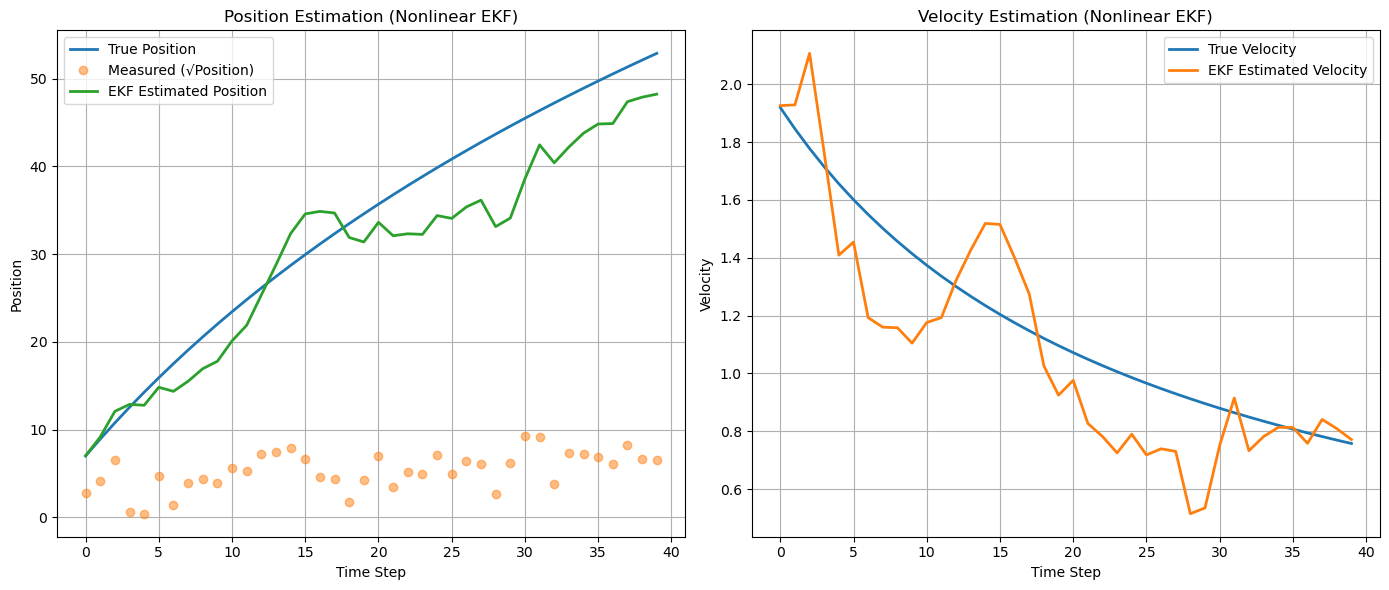

In [19]:

dt = 1.0  # Time step

# Nonlinear motion: constant velocity with quadratic drag
def f(x, u=None):
    pos, vel = x
    drag = 0.02 * vel**2 * np.sign(vel)
    new_pos = pos + vel * dt
    new_vel = vel - drag * dt
    return np.array([new_pos, new_vel])

# Jacobian of f
def F_jacobian(x, u=None):
    pos, vel = x
    d_drag_dv = 0.04 * abs(vel)
    return np.array([
        [1, dt],
        [0, 1 - d_drag_dv * dt]
    ])

def h(x):
    return np.array([np.sqrt(np.abs(x[0]) + 1e-5)])  # small epsilon to avoid sqrt(0)

def H_jacobian(x):
    pos = x[0]
    eps = 1e-5
    return np.array([[0.5 / np.sqrt(np.abs(pos) + eps), 0]])

# ---------- Simulation Setup ----------

x0 = np.array([5.0, 2.0])  # Start at position 5, velocity 2
P0 = np.eye(2) * 1.0
Q = np.diag([0.05, 0.05])  # Process noise
R = np.array([[4.0]])      # Measurement noise (high, due to squaring)

kf = ExtendedKalmanFilter(f, h, F_jacobian, H_jacobian, Q, R, P0, x0)

num_steps = 40
true_states = []
measurements = []
estimates = []

true_x = x0.copy()

for i in range(num_steps):
    # Simulate true motion (nonlinear)
    true_x = f(true_x)
    true_states.append(true_x.copy())

    # Generate nonlinear noisy measurement
    z = h(true_x) + np.random.normal(0, np.sqrt(R[0, 0]), size=(1,))
    measurements.append(z)

    # EKF predict & update
    kf.predict()
    x_est = kf.update(z)
    estimates.append(x_est)

# Convert to arrays for plotting
true_states = np.array(true_states)
estimates = np.array(estimates)
measurements = np.array(measurements).flatten()

# ---------- Plotting ----------

time = np.arange(num_steps)

plt.figure(figsize=(14, 6))

# Plot position
plt.subplot(1, 2, 1)
plt.plot(time, true_states[:, 0], label='True Position', linewidth=2)
plt.plot(time, measurements, 'o', label='Measured (√Position)', alpha=0.5)
plt.plot(time, estimates[:, 0], label='EKF Estimated Position', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Position Estimation (Nonlinear EKF)')
plt.legend()
plt.grid(True)


# Plot velocity
plt.subplot(1, 2, 2)
plt.plot(time, true_states[:, 1], label='True Velocity', linewidth=2)
plt.plot(time, estimates[:, 1], label='EKF Estimated Velocity', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Velocity Estimation (Nonlinear EKF)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()